In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960
DATASET_MAPPING = 'eye-diseases-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2440665%2F4130910%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20230418%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20230418T151621Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6522c3790424c6545aa89ac878637d891a792c645d4faf15f77aadfb75d25e47c103eee5fde3a25a9f523f6f2184444dcc3d10683d53edc84edc5c27e4a398a7602daed4c4e81ad9a8d626b01e7f23173766324ca33f7ba1624f3c5415231b9d0edcb3b4bd3dfc51b453b01ca0ae4457b8c749d71c6947c4af39f0c9cf20d3456c7dc276f77f3a7ea5b74bb8207ebc9a88744eed657f6d87380533a2ad26c9e7a99fbd3a242d8c045c39c0a6cba84ea3c9eb829086b299d0fec3fc40ee40824aed7e90cbc82c9371a14bc5d7dbd78755c7ab2ee359d1ff2db4ecc1aed93dc53cca36645116ec02a3b059d8b1b86cfd025e61370433745a4ecdbbe73cfca6957e'
KAGGLE_INPUT_PATH='/home/kaggle/input'
KAGGLE_INPUT_SYMLINK='/kaggle'

os.makedirs(KAGGLE_INPUT_PATH, 777)
os.symlink(KAGGLE_INPUT_PATH, os.path.join('..', 'input'), target_is_directory=True)
os.makedirs(KAGGLE_INPUT_SYMLINK)
os.symlink(KAGGLE_INPUT_PATH, os.path.join(KAGGLE_INPUT_SYMLINK, 'input'), target_is_directory=True)

for dataset_mapping in DATASET_MAPPING.split(','):
    directory, download_url_encoded = dataset_mapping.split(':')
    download_url = unquote(download_url_encoded)
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
            total_length = zipfileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes zipped')
            dl = 0
            data = zipfileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = zipfileres.read(CHUNK_SIZE)
            print(f'\nUnzipping {directory}')
            with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Dataset import complete.')


# Eye Diseases Classification Dataset

#### Import required libraries, and load the dataset

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

train_ds, dummy_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/eye-diseases-classification/dataset', 
    label_mode='categorical',
    batch_size=128,
    image_size=(200, 200),
    validation_split=0.2, 
    subset='both', 
    seed=123
)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Using 843 files for validation.


In [96]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


### Visualize the data

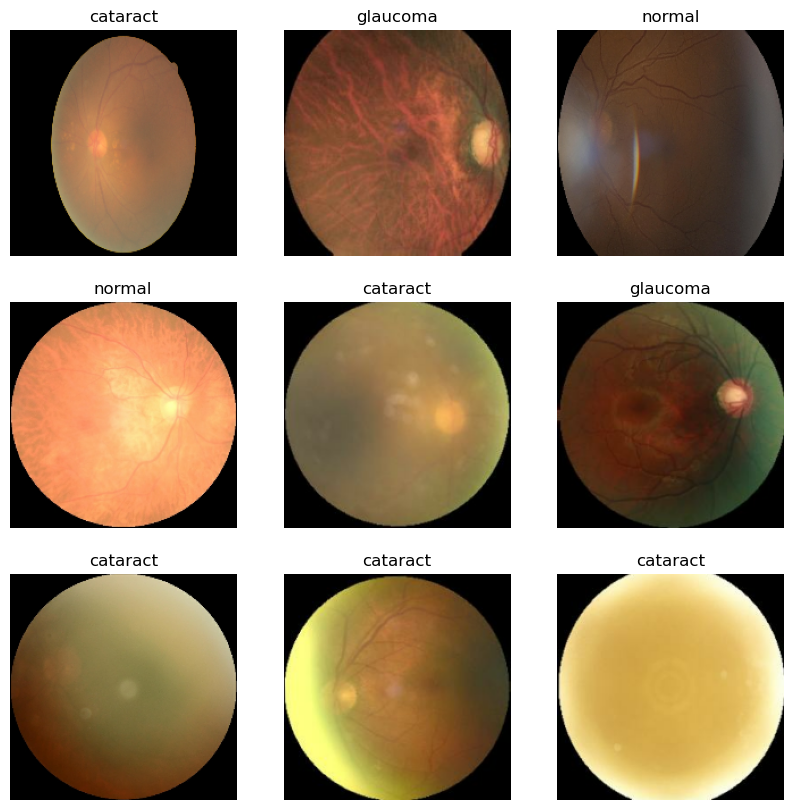

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

### Standardize the data

In [2]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_and_validate_ds = dummy_ds.map(lambda x, y: (normalization_layer(x), y))

### Create validation and testing datasets

In [3]:
validate_batches = tf.data.experimental.cardinality(test_and_validate_ds)
validate_ds = dummy_ds.take(validate_batches // 2)
test_ds = dummy_ds.skip(validate_batches // 2)

### Baseline Model

Create a baseline model without regularization penalties applied to the layers, or dropout used to prevent overfitting.

In [57]:
model_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 200, 3)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_base.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 150528)            0         
                                                                 
 dense_24 (Dense)            (None, 50)                7526450   
                                                                 
 dense_25 (Dense)            (None, 100)               5100      
                                                                 
 dense_26 (Dense)            (None, 4)                 404       
                                                                 
Total params: 7,531,954
Trainable params: 7,531,954
Non-trainable params: 0
_________________________________________________________________


In [60]:
model_base.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [61]:
history = model_base.fit(
    normalized_ds,
    epochs=20,
    validation_data=validate_ds
)

Epoch 1/20
27/27 [==============================] - 21s 565ms/step - loss: 3.8899 - accuracy: 0.4081 - val_loss: 0.9815 - val_accuracy: 0.5885
Epoch 2/20
27/27 [==============================] - 20s 597ms/step - loss: 0.8866 - accuracy: 0.6156 - val_loss: 0.7509 - val_accuracy: 0.6484
Epoch 3/20
27/27 [==============================] - 20s 578ms/step - loss: 0.7608 - accuracy: 0.6618 - val_loss: 0.7632 - val_accuracy: 0.6380
Epoch 4/20
27/27 [==============================] - 19s 567ms/step - loss: 0.7426 - accuracy: 0.6517 - val_loss: 1.0103 - val_accuracy: 0.5859
Epoch 5/20
27/27 [==============================] - 19s 552ms/step - loss: 0.9923 - accuracy: 0.6150 - val_loss: 0.7391 - val_accuracy: 0.6823
Epoch 6/20
27/27 [==============================] - 19s 563ms/step - loss: 0.7296 - accuracy: 0.6752 - val_loss: 0.7410 - val_accuracy: 0.6146
Epoch 7/20
27/27 [==============================] - 19s 557ms/step - loss: 0.7372 - accuracy: 0.6609 - val_loss: 0.6466 - val_accuracy: 0.7526

In [62]:
results = model_base.evaluate(test_ds)

4/4 [==============================] - 4s 563ms/step - loss: 0.5461 - accuracy: 0.7908


In [63]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='upper left')

    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='upper left')

    fig.show()

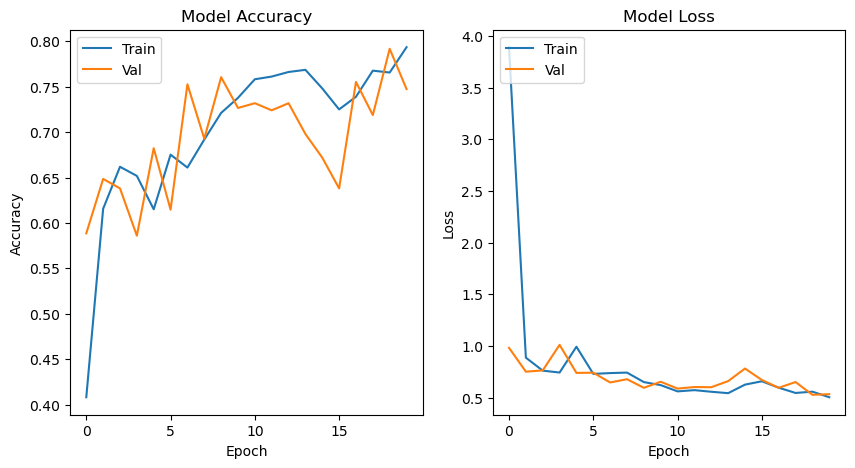

In [64]:
plot_history(history)

### Second Model

Add Dropout layer and kernel regularizers to reduce the gap between training and validation accuracy.

In [100]:
model_optimize = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 200, 3)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_optimize.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 120000)            0         
                                                                 
 dense_48 (Dense)            (None, 128)               15360128  
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_49 (Dense)            (None, 256)               33024     
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_50 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 15,394,180
Trainable params: 15,394,180

In [101]:
model_optimize.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [103]:
history_optimizer = model_optimize.fit(
    normalized_ds,
    epochs=20,
    validation_data=validate_ds
)

Epoch 1/20
27/27 [==============================] - 21s 635ms/step - loss: 1.7388 - accuracy: 0.2688 - val_loss: 107.9231 - val_accuracy: 0.2917
Epoch 2/20
27/27 [==============================] - 20s 587ms/step - loss: 1.6416 - accuracy: 0.2736 - val_loss: 47.6263 - val_accuracy: 0.2917
Epoch 3/20
27/27 [==============================] - 21s 610ms/step - loss: 1.4670 - accuracy: 0.2724 - val_loss: 24.8147 - val_accuracy: 0.2917
Epoch 4/20
27/27 [==============================] - 21s 614ms/step - loss: 1.3981 - accuracy: 0.2893 - val_loss: 14.8460 - val_accuracy: 0.2917
Epoch 5/20
27/27 [==============================] - 21s 625ms/step - loss: 1.3929 - accuracy: 0.3124 - val_loss: 8.4018 - val_accuracy: 0.2943
Epoch 6/20
27/27 [==============================] - 21s 605ms/step - loss: 1.4082 - accuracy: 0.3257 - val_loss: 4.7035 - val_accuracy: 0.2969
Epoch 7/20
27/27 [==============================] - 20s 604ms/step - loss: 1.3758 - accuracy: 0.3373 - val_loss: 2.8091 - val_accuracy: 0

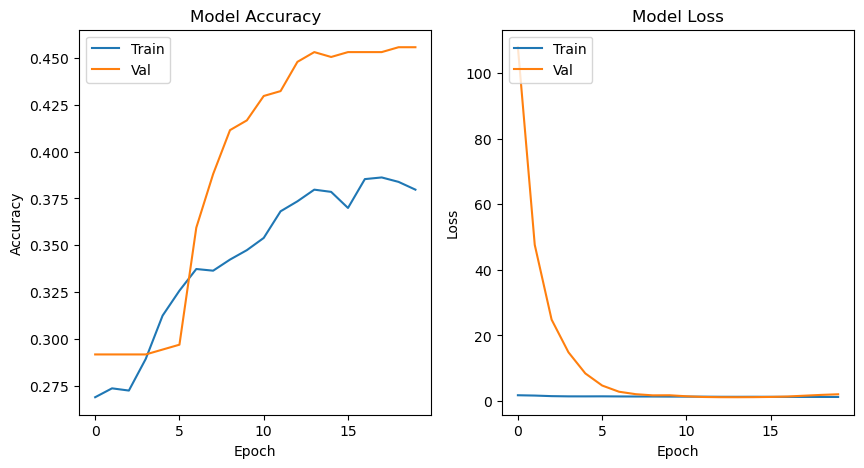

In [104]:
plot_history(history_optimizer)

### Third Model

Create a Convolutional Neural Network (CNN) to improve the accuracy for our image classification model. 

In [4]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(40, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(50, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(60, (3, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(70, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 40)      1120      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 40)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 50)        18050     
                                                                 
 dropout (Dropout)           (None, 97, 97, 50)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 95, 60)        27060     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 60)       0         
 2D)                                                    

In [5]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
cnn_history = cnn_model.fit(
    normalized_ds,
    epochs=5,
    validation_data=validate_ds
)

Epoch 1/5
10/27 [==========>...................] - ETA: 3:07 - loss: 1.4740 - accuracy: 0.2773

KeyboardInterrupt: 

In [108]:
plot_history(cnn_history)

NameError: name 'cnn_history' is not defined